In [7]:
# -*- coding: utf-8 -*-
import random
import math
import matplotlib.pyplot as plt

In [4]:
class BernoulliArm(object):
    def __init__(self, p):
        self.p = p
        
    def step(self):
        if random.random() < self.p:
            return 1.0
        else:
            return 0.0

### A/B Testing
向用户随机展示两张图片，一段时间后，哪张图片的点击率高，就用哪张。对应到多臂老虎机问题，一张图片，便是多臂老虎机的一个臂。

In [6]:
class ABTest(object):
    
    def __init__(self, arm_n):
        self.arm_n = arm_n
    
    def pull(self):
        return random.choice(range(self.arm_n))
    
    def update(self, arm, reward):
        pass
    
    def __str__(self):
        return 'ab test'
    
    def __repr__(self):
        return 'ABTest(arm_n)'.format(arm_n=self.arm_n)

### Epsilon Greedy
与A/B Testing 相比，Epsilon Greedy 控制了随机使用老虎机的次数。

其中平均回报率的计算为，设$R_n$为使用n次老虎机后的平均回报，$r_{n+1}$为第n+1次的回报，则
$$R_{n+1}=\frac{R_n \times n + r_{n+1}}{n+1} = R_n + \frac{r_{n+1}-R_n}{n+1}$$

In [16]:
class EpsilonGreedy(object):
    
    def __init__(self, arm_n, epsilon):
        self.arm_n = arm_n
        self.epsilon = epsilon
        self.counts = [0.0 for _ in range(self.arm_n)] # 记录每个臂被使用的次数
        self.values = [0.0 for _ in range(self.arm_n)] # 记录每个臂的回报
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        
    def pull(self):
        """
        其中由1-epsilon的概率，做exploit
        """
        for arm in range(self.arm_n):
            if self.counts[arm] == 0:
                return arm
            
        if random.random() < self.epsilon: # explore，随机选择臂
            return random.choice(range(self.arm_n))
        else: # exploit，选择历史回报最高的臂
            m = max(self.values)
            return self.values.index(m)
    
    def __str__(self):
        return 'epsilon greedy: %s' % self.epsilon
    
    def __repr__(self):
        return 'epsilon greedy (arm_n, epsilon)'.format(arm_n=self.arm_n, epsilon=self.epsilon)

### Softmax Strategy
Epsilon-greedy 对于不同性能的臂是不敏感的，而softmax的方法能够根据臂的历史回报值调整选择该臂的概率。

$$p_k = \frac{\exp(\frac{\hat{\mu}_k}{\tau})}{\sum_{i=1}^n\exp(\frac{\hat{\mu}_i}{\tau})}$$

In [18]:
class Softmax(object):
    
    def __init__(self, arm_n, temperature):
        self.arm_n = arm_n
        self.temperature = temperature
        self.counts = [0.0 for _ in range(self.arm_n)]
        self.values = [0.0 for _ in range(self.arm_n)]
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        
    def pull(self):
        for arm in range(self.arm_n):
            if self.counts[arm] == 0:
                return arm
            
        s = sum([math.exp(v/self.temperature) for v in self.values])
        probs = [math.exp(v/self.temperature) / s for v in self.values]
        m = max(probs)
        return probs.index(m)
    
    def __str__(self):
        return 'softmax: %s' % self.temperature
        
    def __repr__(self):
        return 'Softmax(arm_n, temperature)'.format(arm_n=self.arm_n, temperature=self.temperature)

### UCB1
根据下面的公式进行更新

$$ i_t = \arg\max \bigg[ \hat{\mu}_i + \sqrt{\frac{c\log t}{n_i}} \bigg]$$

In [23]:
class UCB1(object):
    
    def __init__(self, arm_n):
        self.arm_n = arm_n
        self.counts = [0.0 for _ in range(self.arm_n)]
        self.values = [0.0 for _ in range(self.arm_n)]
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        
    def pull(self):
        for arm in range(self.arm_n):
            if self.counts[arm] == 0:
                return arm
        
        t = sum(self.counts)
        ucbs = [self.values[arm] + math.sqrt((2*math.log(t))/self.counts[arm]) for arm in range(self.arm_n)]
        m = max(ucbs)
        return ucbs.index(m)
        
    def __str__(self):
        return 'ucb1'
        
    def __repr__(self):
        return 'UCB1(arm_n)'.format(arm_n=self.arm_n)

### 实验比较

In [9]:
arms = [BernoulliArm(0.1), BernoulliArm(0.1), BernoulliArm(0.1), BernoulliArm(0.1), BernoulliArm(0.9)]

In [10]:
def algorithm_demo(arms, algorithm, episodes):
    """
    s: 平均回报率的变化
    """
    r, s = 0.0, []
    for episode in range(episodes):
        arm = algorithm.pull()
        reward = arms[arm].step()
        algorithm.update(arm, reward)
        r += reward
        s.append(r/(episode+1))
    return s

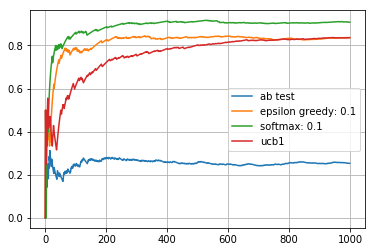

(<matplotlib.legend.Legend at 0x108d37dd8>, None, None)

In [25]:
algorithms = [ABTest(5), EpsilonGreedy(5,0.1), Softmax(5,0.1), UCB1(5)]
ss = [algorithm_demo(arms, algorithm, 1000) for algorithm in algorithms]
[plt.plot(range(1000), ss[i], label=str(algorithms[i])) for i in range(4)]
plt.legend(), plt.grid(), plt.show()